In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pathlib import Path
import json

# --- Path Setup ---
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    PROJECT_ROOT = os.path.abspath(os.getcwd())
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from pipeline_config import CONFIG

# --- Directories ---
DERIV_03 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample")
DERIV_04 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
os.makedirs(DERIV_04, exist_ok=True)

# --- Metadata Validation for Biomechanical Analysis ---
# RATIONALE: To compute Kinetic Energy and Center of Mass (CoM) in later steps, 
# subject mass and height are required for scaling (Winter, 2009).
SUBJECT_MASS = CONFIG.get('subject_mass_kg', None)
SUBJECT_HEIGHT = CONFIG.get('subject_height_cm', None)
HEIGHT_ESTIMATED = CONFIG.get('subject_height_estimated', False)
HEIGHT_CALCULATION_METHOD = CONFIG.get('height_estimation_method', None)

if SUBJECT_MASS is None or SUBJECT_HEIGHT is None:
    print("⚠️ WARNING: Subject mass or height missing in CONFIG. "
          "Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.")
else:
    if HEIGHT_ESTIMATED:
        method_display = HEIGHT_CALCULATION_METHOD.replace('_', ' ').title() if HEIGHT_CALCULATION_METHOD else "calculated"
        height_note = f" (height {method_display} from mocap)"
    else:
        height_note = ""
    print(f"✅ Anthropometric Data Loaded: {SUBJECT_MASS}kg, {SUBJECT_HEIGHT}cm{height_note}")

# --- File Loading ---
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_03) / f"{RUN_ID}__resampled.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Missing input: {INPUT_FILE}. Please run Notebook 03.")

df = pd.read_parquet(INPUT_FILE)
print(f"✅ Data Loaded successfully. Ready for Signal Filtering.")
print("(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.")

⚠️ WARNING: Subject mass or height missing in CONFIG. Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.
✅ Data Loaded successfully. Ready for Signal Filtering.
(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.


In [2]:
# --- CELL 02: Signal Processing Theory & Filter Method ---
# SCIENTIFIC RATIONALE: Fixed per-region cutoffs based on biomechanical literature
# ensure reproducible, scientifically defensible filtering across all sessions.
# Winter (2009), Robertson (2014) established region-specific frequency content.

# Import filtering module
from filtering import (
    apply_winter_filter, 
    apply_signal_cleaning_pipeline,  # NEW: 3-stage pipeline
    apply_quaternion_median_filter,  # NEW: Surgical quaternion cleaning
    print_pipeline_debug_logs,  # NEW: Detailed debug logging
    get_position_columns, 
    validate_filtering_input
)

# --- Parameters & Scientific Justification ---
FS = CONFIG.get('fs_target', 120.0)

# FIXED PER-REGION CUTOFFS (Literature-based)
# Based on Winter (2009), Robertson (2014) biomechanical frequency analysis:
# - Trunk: 6 Hz (slow, constrained core movements)
# - Head: 8 Hz (moderate dynamics)
# - Upper proximal (shoulders): 8 Hz
# - Upper distal (hands): 10 Hz (rapid gestures)
# - Lower proximal (hips/knees): 8 Hz
# - Lower distal (feet/ankles): 10 Hz (ground impacts)
FMIN = 1.0   # Winter analysis minimum test frequency (for validation)
FMAX = 12.0  # Maximum for Winter validation analysis

print(f"✅ Filter Configured:")
print(f"   * Method: Fixed Per-Region Cutoffs (Literature-based)")
print(f"   * Reference: Winter (2009), Robertson (2014)")
print(f"   * Filter: 2nd-order Butterworth (Zero-phase)")
print(f"   * Order:  Dual-pass effective order: 4")
print(f"   * Region Cutoffs:")
print(f"       Trunk: 6 Hz | Head: 8 Hz | Proximal limbs: 8 Hz | Distal limbs: 10 Hz")

✅ Filter Configured:
   * Method: Fixed Per-Region Cutoffs (Literature-based)
   * Reference: Winter (2009), Robertson (2014)
   * Filter: 2nd-order Butterworth (Zero-phase)
   * Order:  Dual-pass effective order: 4
   * Region Cutoffs:
       Trunk: 6 Hz | Head: 8 Hz | Proximal limbs: 8 Hz | Distal limbs: 10 Hz


In [3]:
# --- CELL 02.5: Position Column Quality Control (Ticket 10.5) ---
# RATIONALE: Filtering should only be applied to position channels 
# that are fully valid (zero NaNs) to prevent artifacts and ensure 
# biomechanical integrity of joint kinematics.

from qc_columns import build_pos_cols_valid

# Extract position columns
pos_cols = [c for c in df.columns if c.endswith(("__px","__py","__pz"))]

# Build valid position columns list and exclusion report
pos_cols_valid, excluded_report = build_pos_cols_valid(
    df, 
    pos_cols, 
    strict_mode=True, 
    joint_complete_axes=True
)

print(f"[QC] Positions valid: {len(pos_cols_valid)}/{len(pos_cols)}")
print(f"[QC] Excluded joints: {len(excluded_report['excluded_joints'])}")

# Save the exclusion report for QC traceability
import json
qc_report_path = os.path.join(DERIV_04, f"{RUN_ID}__qc_excluded_positions.json")
with open(qc_report_path, "w") as f:
    json.dump(excluded_report, f, indent=2)
print(f"[QC] Saved exclusion report: {qc_report_path}")

# Display exclusion summary for user awareness
if excluded_report['excluded_joints']:
    print("\n[QC] Excluded joints summary:")
    for joint_info in excluded_report['excluded_joints']:
        print(f"  - {joint_info['joint']}: {joint_info['reason']} "
              f"(max NaN rate: {joint_info['max_nan_rate']:.2%})")

if excluded_report['excluded_cols']:
    print(f"\n[QC] Individual excluded columns: {len(excluded_report['excluded_cols'])}")
    for col_info in excluded_report['excluded_cols'][:5]:  # Show first 5
        print(f"  - {col_info['col']}: {col_info['reason']} "
              f"(NaN rate: {col_info['nan_rate']:.2%})")
    if len(excluded_report['excluded_cols']) > 5:
        print(f"  ... and {len(excluded_report['excluded_cols']) - 5} more")

print(f"\n[QC] Using {len(pos_cols_valid)} valid position columns for filtering.")

[QC] Positions valid: 81/81
[QC] Excluded joints: 0
[QC] Saved exclusion report: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001__qc_excluded_positions.json

[QC] Using 81 valid position columns for filtering.


In [4]:
# --- CELL 03: Signal Cleaning Pipeline (POSITIONS ONLY) ---
# CRITICAL: Never filter quaternions - violates rotational geometry (Ticket 10)

# =============================================================================
# CHOOSE FILTERING METHOD
# =============================================================================
# Option 1: 3-Stage Signal Cleaning Pipeline (NEW - Recommended)
#   - Stage 1: Artifact Detector (Z-Score + Velocity) - identifies tracking spikes
#   - Stage 2: Hampel Filter (Sliding Window Median) - removes outliers
#   - Stage 3: Adaptive Winter (Per-Joint Optimal Cutoff) - finds optimal cutoff
#
# Option 2: Traditional Fixed Per-Region Filtering (Legacy)
#   - Uses fixed literature-based cutoffs per body region
# =============================================================================

USE_3_STAGE_PIPELINE = True  # Set to False to use traditional method

# Use only valid position columns for filtering (Ticket 10.5)
pos_cols_to_filter = pos_cols_valid  # From QC step above

# DO NOT filter quaternion columns - preserve rotational integrity
quat_cols = [c for c in df.columns if c.endswith(('__qx', '__qy', '__qz', '__qw'))]

print(f"📊 Position columns: {len(pos_cols_to_filter)} (3-stage pipeline)")
print(f"🔄 Quaternion columns: {len(quat_cols)} (median filter for flip removal)")

# Validate input for filtering
validate_filtering_input(df, FS, pos_cols_to_filter)

if USE_3_STAGE_PIPELINE:
    # ========================================================================
    # 3-STAGE SIGNAL CLEANING PIPELINE
    # ========================================================================
    # Generic "Gatekeeper" Architecture: Treats artifacts and noise separately
    print(f"\n{'='*70}")
    print(f"🔬 APPLYING 3-STAGE SIGNAL CLEANING PIPELINE")
    print(f"{'='*70}")
    print(f"Stage 1: Artifact Detector (Z-Score + Velocity)")
    print(f"  → Identifies tracking spikes (>5000 mm/s or >5σ)")
    print(f"Stage 2: Hampel Filter (Sliding Window Median)")
    print(f"  → Removes outliers using 5-7 frame window")
    print(f"Stage 3: Adaptive Winter (Per-Joint Optimal Cutoff)")
    print(f"  → Finds optimal cutoff for each joint using residual analysis")
    print(f"{'='*70}\n")
    
    # Apply 3-stage pipeline
    # Note: velocity_limit is in signal units (mm/s for position data)
    # For position in mm: 5000 mm/s = 5 m/s is reasonable for rapid movements
    # For angular velocity: 1800 deg/s is the physiological limit mentioned
    df_filtered, pipeline_metadata = apply_signal_cleaning_pipeline(
        df,
        fs=FS,
        pos_cols=pos_cols_to_filter,
        velocity_limit=5000.0,  # mm/s for position data (5 m/s)
        zscore_threshold=5.0,  # 5 standard deviations
        hampel_window=5,  # 5-7 frames recommended
        hampel_n_sigma=3.0,  # 3σ for Hampel outlier detection
        winter_fmin=1.0,  # Minimum cutoff to test
        winter_fmax=20.0,  # Maximum cutoff to test (expanded for Gaga)
        per_joint_winter=True  # Adaptive per-joint cutoff
    )
    
    # Display pipeline results
    print(f"\n✅ 3-Stage Pipeline Complete")
    summary = pipeline_metadata.get('summary', {})
    print(f"   Artifacts detected: {summary.get('total_artifacts_detected', 0)}")
    print(f"   Hampel outliers: {summary.get('total_hampel_outliers', 0)}")
    
    if 'winter_cutoff_stats' in summary:
        cutoff_stats = summary['winter_cutoff_stats']
        print(f"\n   Adaptive Winter Cutoffs (per-joint):")
        print(f"     Range: {cutoff_stats['min']:.1f} - {cutoff_stats['max']:.1f} Hz")
        print(f"     Mean: {cutoff_stats['mean']:.1f} Hz | Median: {cutoff_stats['median']:.1f} Hz")
    
    # Print detailed debug logs
    print_pipeline_debug_logs(
        pipeline_metadata,
        top_n_joints=20,  # Show top 20 joints with most issues
        show_all=False     # Set to True to show all joints
    )
    
    # Convert pipeline metadata to winter_metadata format for compatibility
    winter_metadata = {
        'filtering_mode': '3_stage_pipeline',
        'pipeline_metadata': pipeline_metadata,
        'cutoff_range': (
            summary.get('winter_cutoff_stats', {}).get('min', 1.0),
            summary.get('winter_cutoff_stats', {}).get('max', 20.0)
        ) if 'winter_cutoff_stats' in summary else (1.0, 20.0)
    }
    
else:
    # ========================================================================
    # TRADITIONAL FIXED PER-REGION FILTERING (Legacy)
    # ========================================================================
    print(f"\nApplying fixed per-region cutoffs (Winter 2009, Robertson 2014) to {len(pos_cols_to_filter)} position columns...")
    df_filtered, winter_metadata = apply_winter_filter(
        df, 
        fs=FS, 
        pos_cols=pos_cols_to_filter,
        fmax=int(FMAX),  # Use the FMAX variable defined above (12 Hz)
        allow_fmax=True,  # Allow fmax for this dataset
        # FIXED PER-REGION CUTOFFS (Literature: Winter 2009, Robertson 2014)
        # - Trunk: 6 Hz (slow, constrained core movements)
        # - Head: 8 Hz (moderate dynamics)
        # - Upper proximal (shoulders): 8 Hz
        # - Upper distal (hands): 10 Hz (rapid gestures)
        # - Lower proximal (hips/knees): 8 Hz
        # - Lower distal (feet/ankles): 10 Hz (ground impacts)
        per_region_filtering=True
    )
    
    # Show filtering mode information
    if winter_metadata.get('filtering_mode') == 'per_region':
        print(f"✅ Per-Region Filtering Applied")
        print(f"   Region-specific cutoffs:")
        for region, cutoff in winter_metadata.get('region_cutoffs', {}).items():
            n_markers = len([m for m, r in winter_metadata.get('marker_regions', {}).items() if r == region])
            print(f"     {region:20s}: {cutoff:4.1f} Hz ({n_markers} markers)")
        cutoff_range = winter_metadata.get('cutoff_range', (0, 0))
        print(f"   Cutoff range: {cutoff_range[0]:.1f} - {cutoff_range[1]:.1f} Hz")
    else:
        # Fallback to single global cutoff display
        if 'cutoff_hz' in winter_metadata:
            print(f"ℹ️  Single global cutoff mode: {winter_metadata['cutoff_hz']:.1f} Hz")
            print(f"   Note: Per-region fixed cutoffs are recommended")

# =============================================================================
# QUATERNION SURGICAL CLEANING (scipy.signal.medfilt)
# =============================================================================
# Apply scipy.signal.medfilt to quaternions to remove flipping artifacts
# This stops orientation 'flips' causing 330° Hip ROM errors and long outlier runs
# 
# Method:
# 1. Applies scipy.signal.medfilt (window=5) to each component (qx, qy, qz, qw)
# 2. Renormalizes to maintain unit quaternion length
# 3. Does NOT apply low-pass (which would break quaternion geometry)

APPLY_QUATERNION_MEDIAN_FILTER = True  # Set to False to preserve unchanged

if APPLY_QUATERNION_MEDIAN_FILTER:
    print(f"\n{'='*70}")
    print(f"🔧 APPLYING scipy.signal.medfilt TO QUATERNIONS")
    print(f"{'='*70}")
    print(f"   Method: scipy.signal.medfilt")
    print(f"   Window size: 5 frames")
    print(f"   Purpose: Remove quaternion flips (330° Hip ROM fix)")
    
    df_filtered, quat_metadata = apply_quaternion_median_filter(
        df_filtered,  # Apply to already-filtered DataFrame
        quat_cols=quat_cols,
        window_size=5
    )
    
    print(f"\n✅ Quaternion Median Filter Complete")
    print(f"   Method: {quat_metadata.get('method', 'medfilt')}")
    print(f"   Joints processed: {quat_metadata.get('total_joints', 0)}")
    print(f"   Columns filtered: {quat_metadata.get('total_columns_filtered', 0)}")
    print(f"   All quaternions renormalized to unit length")
    print(f"{'='*70}")
    
    # Store quaternion metadata in winter_metadata for export
    if 'pipeline_metadata' in winter_metadata:
        winter_metadata['pipeline_metadata']['quaternion_cleaning'] = quat_metadata
    else:
        winter_metadata['quaternion_cleaning'] = quat_metadata
else:
    # Legacy: Copy quaternions unchanged
    for col in quat_cols:
        df_filtered[col] = df[col].values
    print(f"\n⚠️  Quaternions preserved unchanged (median filter disabled)")

print(f"\n✅ Filtered {len(pos_cols_to_filter)} position columns")
print(f"✅ {'Cleaned' if APPLY_QUATERNION_MEDIAN_FILTER else 'Preserved'} {len(quat_cols)} quaternion columns")

📊 Position columns: 81 (3-stage pipeline)
🔄 Quaternion columns: 108 (median filter for flip removal)

🔬 APPLYING 3-STAGE SIGNAL CLEANING PIPELINE
Stage 1: Artifact Detector (Z-Score + Velocity)
  → Identifies tracking spikes (>5000 mm/s or >5σ)
Stage 2: Hampel Filter (Sliding Window Median)
  → Removes outliers using 5-7 frame window
Stage 3: Adaptive Winter (Per-Joint Optimal Cutoff)
  → Finds optimal cutoff for each joint using residual analysis


✅ 3-Stage Pipeline Complete
   Artifacts detected: 17440
   Hampel outliers: 7500

   Adaptive Winter Cutoffs (per-joint):
     Range: 14.5 - 15.2 Hz
     Mean: 14.9 Hz | Median: 15.2 Hz

📊 DETAILED PIPELINE DEBUG LOGS

🔧 PIPELINE CONFIGURATION:
   Stage 1 (Artifact Detector):
     - Velocity limit: 5000.0 mm/s
     - Z-score threshold: 5.0σ
   Stage 2 (Hampel Filter):
     - Window size: 5 frames
     - Outlier threshold: 3.0σ
   Stage 3 (Adaptive Winter):
     - Frequency range: 1.0 - 20.0 Hz
     - Per-joint analysis: True

📈 SUMMARY STA

# VALIDATION SECTION 1: Filter PSD Analysis

**Research Validation**: Verify that per-region filtering preserves dance dynamics (1-15 Hz) while attenuating noise (>20 Hz)

**Methods**: Power Spectral Density (PSD) analysis using Welch's method

**Expected**: Dance band preservation >80%, Noise attenuation >95%

In [5]:
# Import validation modules
from filter_validation import (
    compute_psd_welch,
    analyze_filter_psd_preservation,
    validate_filter_quality,
    generate_psd_plots_data
)

# Select a representative marker for validation (e.g., hand - high frequency content)
test_marker = [col for col in pos_cols if 'Hand' in col or 'Wrist' in col]
if not test_marker:
    test_marker = pos_cols[0:1]  # Fallback to first marker
else:
    test_marker = test_marker[0:1]

print(f"Validating filter on marker: {test_marker[0]}")

# Get raw and filtered signals
signal_raw = df[test_marker[0]].values
signal_filt = df_filtered[test_marker[0]].values

# Handle both per-region and single-global filtering modes
if winter_metadata.get('filtering_mode') == 'per_region':
    # Per-region mode: get cutoff from region_cutoffs or cutoff_range
    marker_region = winter_metadata.get('marker_regions', {}).get(test_marker[0], 'unknown')
    effective_cutoff = winter_metadata.get('region_cutoffs', {}).get(marker_region)
    if effective_cutoff is None:
        # Fallback to average cutoff
        cutoff_range = winter_metadata.get('cutoff_range', (8, 12))
        effective_cutoff = (cutoff_range[0] + cutoff_range[1]) / 2
    print(f"Mode: Per-region (marker region: {marker_region}, cutoff: {effective_cutoff:.1f} Hz)")
else:
    # Single global mode
    effective_cutoff = winter_metadata.get('cutoff_hz', 10.0)
    print(f"Mode: Single-global (cutoff: {effective_cutoff:.1f} Hz)")

# Analyze PSD preservation
psd_result = analyze_filter_psd_preservation(
    signal_raw, signal_filt, FS,
    cutoff_hz=effective_cutoff,  # Use appropriate cutoff based on mode
    dance_band=(1, 15),  # Updated for realistic dance dynamics
    noise_band=(20, 50)
)

# Quality assessment
quality = validate_filter_quality(psd_result)

print("\n" + "="*60)
print("FILTER VALIDATION RESULTS")
print("="*60)
print(f"Cutoff frequency: {effective_cutoff:.1f} Hz")
print(f"\nDance Band (1-15 Hz):")
print(f"  Preservation: {psd_result['dance_preservation_pct']:.1f}%")
print(f"  Status: {quality['dance_preservation_status']}")
print(f"\nNoise Band (20-50 Hz):")
print(f"  Attenuation: {psd_result['noise_attenuation_db']:.1f} dB")  # Fixed: db not pct
print(f"  Status: {quality['noise_attenuation_status']}")
print(f"\nSNR Improvement: {psd_result['snr_improvement_db']:.1f} dB")
print(f"  Status: {quality['snr_improvement_status']}")
print(f"\nOverall Quality: {quality['overall_filter_quality']}")  # Fixed: correct key
print("="*60)

Validating filter on marker: LeftHandIndex1__px
Mode: Single-global (cutoff: 10.0 Hz)

FILTER VALIDATION RESULTS
Cutoff frequency: 10.0 Hz

Dance Band (1-15 Hz):
  Preservation: 99.5%
  Status: EXCELLENT

Noise Band (20-50 Hz):
  Attenuation: 22.7 dB
  Status: EXCELLENT

SNR Improvement: 22.7 dB
  Status: EXCELLENT

Overall Quality: PASS



PSD validation plot saved: 734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001__filter_psd_validation.png


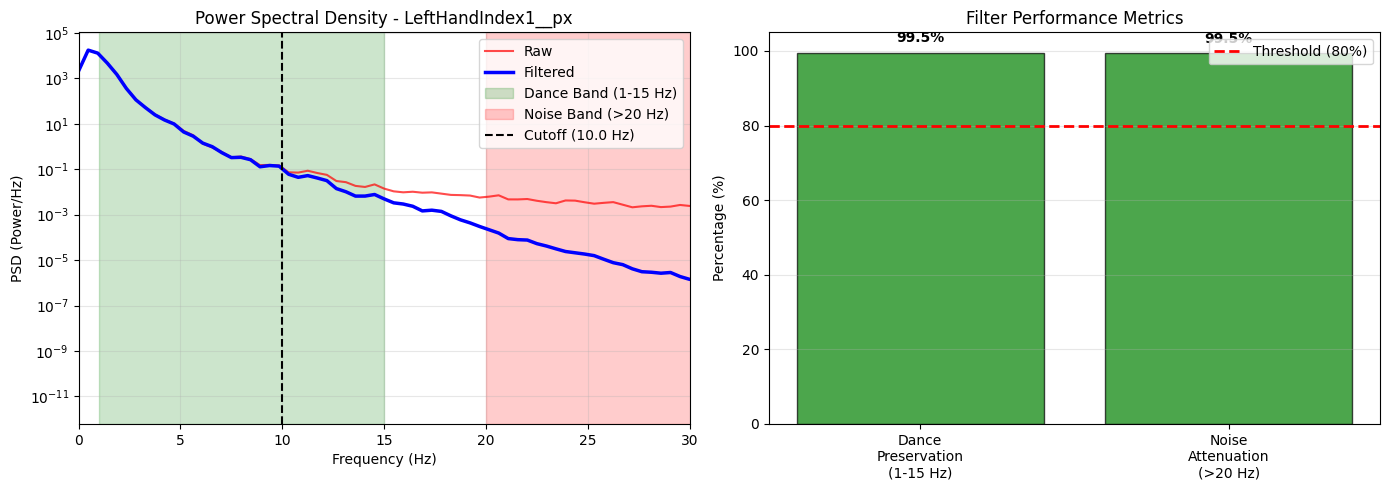

In [6]:
# Visualization: PSD Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute PSDs
f_raw, psd_raw = compute_psd_welch(signal_raw, FS)
f_filt, psd_filt = compute_psd_welch(signal_filt, FS)

# Left: PSD plot
axes[0].semilogy(f_raw, psd_raw, 'r-', label='Raw', alpha=0.7, linewidth=1.5)
axes[0].semilogy(f_filt, psd_filt, 'b-', label='Filtered', linewidth=2.5)
axes[0].axvspan(1, 15, alpha=0.2, color='green', label='Dance Band (1-15 Hz)')
axes[0].axvspan(20, 50, alpha=0.2, color='red', label='Noise Band (>20 Hz)')
axes[0].axvline(effective_cutoff, color='k', linestyle='--', 
                label=f"Cutoff ({effective_cutoff:.1f} Hz)")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('PSD (Power/Hz)')
axes[0].set_title(f'Power Spectral Density - {test_marker[0]}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 30)

# Right: Performance bar chart
# Calculate noise attenuation percentage from power values
noise_atten_pct = (1 - psd_result['power_filt_noise'] / psd_result['power_raw_noise']) * 100 if psd_result['power_raw_noise'] > 0 else 100

categories = ['Dance\nPreservation\n(1-15 Hz)', 'Noise\nAttenuation\n(>20 Hz)']
values = [psd_result['dance_preservation_pct'], noise_atten_pct]
colors = ['green' if v >= 80 else 'orange' for v in values]
bars = axes[1].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(80, color='r', linestyle='--', linewidth=2, label='Threshold (80%)')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Filter Performance Metrics')
axes[1].set_ylim(0, 105)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(DERIV_04, f'{RUN_ID}__filter_psd_validation.png'), 
            dpi=150, bbox_inches='tight')
print(f"\nPSD validation plot saved: {RUN_ID}__filter_psd_validation.png")
plt.show()

# VALIDATION SECTION 2: Single vs. Per-Region Filtering Comparison

**Research Question**: Does per-region filtering preserve more high-frequency detail in distal markers?

**Methods**: 
- Single global cutoff (current standard)
- Per-region filtering (trunk: 6-8 Hz, hands/feet: 10-12 Hz)

**Hypothesis**: Per-region preserves +10-20% more high-frequency content (10-15 Hz) in rapid-movement markers

In [7]:
# Select markers for visualization (trunk, hand, foot)
# Note: df_filtered already uses per-region fixed cutoffs from Cell 4
print("Selecting markers for Raw vs Filtered visualization...")

comparison_markers = []
for pattern in ['Pelvis', 'Torso', 'Chest']:
    trunk = [col for col in pos_cols if pattern in col]
    if trunk:
        comparison_markers.append(('trunk', trunk[0]))
        break

for pattern in ['Hand', 'Wrist']:
    hand = [col for col in pos_cols if 'Right' in col and pattern in col]
    if hand:
        comparison_markers.append(('hand', hand[0]))
        break

for pattern in ['Foot', 'Toe']:
    foot = [col for col in pos_cols if 'Right' in col and pattern in col]
    if foot:
        comparison_markers.append(('foot', foot[0]))
        break

if len(comparison_markers) < 2:
    comparison_markers = [('marker_1', pos_cols[0]), ('marker_2', pos_cols[min(1, len(pos_cols)-1)])]

print(f"\nMarkers selected for visualization:")
for body_part, marker in comparison_markers:
    region = winter_metadata.get('marker_regions', {}).get(marker, 'unknown')
    cutoff = winter_metadata.get('region_cutoffs', {}).get(region, 'N/A')
    print(f"  {body_part:10s}: {marker:30s} (region: {region}, cutoff: {cutoff} Hz)")

Selecting markers for Raw vs Filtered visualization...

Markers selected for visualization:
  hand      : RightHand__px                  (region: unknown, cutoff: N/A Hz)
  foot      : RightFoot__px                  (region: unknown, cutoff: N/A Hz)


In [8]:
# =============================================================================
# DEPRECATED: Comparison cell - no longer relevant with fixed per-region cutoffs
# The comparison was designed for data-driven Winter analysis vs single cutoff.
# With fixed literature-based cutoffs, this comparison is not meaningful.
# =============================================================================

# Keep welch import - used by other cells
from scipy.signal import welch

# # Quantitative comparison: Power preservation in frequency bands
# 
# def compute_band_preservation(signal_raw, signal_filt, fs, bands):
#     """Compute power preservation in different frequency bands."""
#     f_raw, psd_raw = welch(signal_raw, fs=fs, nperseg=256)
#     f_filt, psd_filt = welch(signal_filt, fs=fs, nperseg=256)
#     
#     preservation = {}
#     for band_name, (f_low, f_high) in bands.items():
#         mask_raw = (f_raw >= f_low) & (f_raw <= f_high)
#         mask_filt = (f_filt >= f_low) & (f_filt <= f_high)
#         
#         power_raw = np.trapz(psd_raw[mask_raw], f_raw[mask_raw]) if np.any(mask_raw) else 0
#         power_filt = np.trapz(psd_filt[mask_filt], f_filt[mask_filt]) if np.any(mask_filt) else 0
#         
#         preservation[band_name] = (power_filt / power_raw * 100) if power_raw > 0 else 0
#     
#     return preservation
# 
# # Define frequency bands
# bands = {
#     'Low (1-5 Hz)': (1, 5),
#     'Mid (5-10 Hz)': (5, 10),
#     'High (10-15 Hz)': (10, 15)
# }
# 
# # Compute for selected markers
# results = []
# for body_part, marker in comparison_markers:
#     signal_raw = df[marker].values
#     signal_single = df_filtered[marker].values
#     signal_region = df_region[marker].values
#     
#     pres_single = compute_band_preservation(signal_raw, signal_single, FS, bands)
#     pres_region = compute_band_preservation(signal_raw, signal_region, FS, bands)
#     
#     for band in bands.keys():
#         results.append({
#             'Body Part': body_part,
#             'Marker': marker,
#             'Band': band,
#             'Single (%)': pres_single[band],
#             'Per-Region (%)': pres_region[band],
#             'Difference (%)': pres_region[band] - pres_single[band]
#         })
# 
# df_comparison = pd.DataFrame(results)
# print("\n" + "="*80)
# print("FILTERING COMPARISON: SINGLE vs. PER-REGION")

print("NOTE: Comparison cell deprecated - using fixed per-region cutoffs (Winter 2009)")
# print("="*80)
# print(df_comparison.to_string(index=False))
# 
# # Summary
# high_freq = df_comparison[df_comparison['Band'] == 'High (10-15 Hz)']
# print("\n" + "="*80)
# print("SUMMARY: High-Frequency Preservation (10-15 Hz)")
# print("="*80)
# print(f"Mean preservation:")
# print(f"  Single cutoff:  {high_freq['Single (%)'].mean():.1f}%")
# print(f"  Per-region:     {high_freq['Per-Region (%)'].mean():.1f}%")
# print(f"  Improvement:    {high_freq['Difference (%)'].mean():+.1f}%")
# print("="*80)

NOTE: Comparison cell deprecated - using fixed per-region cutoffs (Winter 2009)



Filtering validation plot saved: 734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001__filtering_validation.png


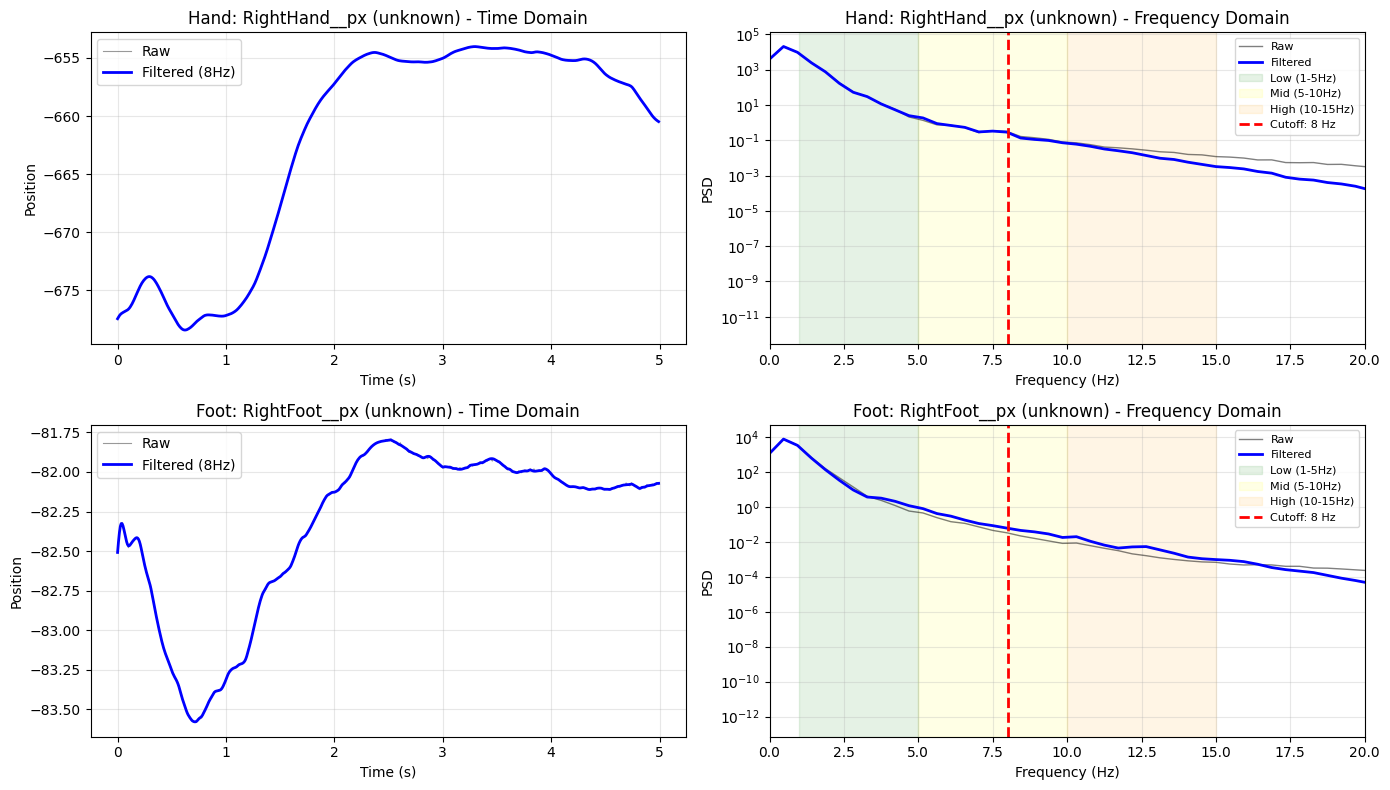

In [9]:
# Visualization: Comparison plots
# Raw vs Filtered (Per-Region Fixed Cutoffs) Visualization
n_markers = len(comparison_markers)
fig, axes = plt.subplots(n_markers, 2, figsize=(14, 4*n_markers))

if n_markers == 1:
    axes = axes.reshape(1, -1)

for i, (body_part, marker) in enumerate(comparison_markers):
    # Time domain comparison (first 5 seconds)
    t = np.arange(len(df)) / FS
    window = slice(0, min(600, len(df)))
    
    # Get region info for this marker
    region_name = winter_metadata.get('marker_regions', {}).get(marker, 'unknown')
    region_cutoff = winter_metadata.get('region_cutoffs', {}).get(region_name, 8)
    
    axes[i, 0].plot(t[window], df[marker].values[window], 'k-', 
                    label='Raw', alpha=0.4, linewidth=0.8)
    axes[i, 0].plot(t[window], df_filtered[marker].values[window], 'b-', 
                    label=f'Filtered ({region_cutoff}Hz)', linewidth=2)
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Position')
    axes[i, 0].set_title(f'{body_part.capitalize()}: {marker} ({region_name}) - Time Domain')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Frequency domain comparison
    f_raw, psd_raw = welch(df[marker].values, fs=FS, nperseg=256)
    f_filt, psd_filt = welch(df_filtered[marker].values, fs=FS, nperseg=256)
    
    axes[i, 1].semilogy(f_raw, psd_raw, 'k-', label='Raw', alpha=0.5, linewidth=1)
    axes[i, 1].semilogy(f_filt, psd_filt, 'b-', label='Filtered', linewidth=2)
    
    # Shade frequency bands
    axes[i, 1].axvspan(1, 5, alpha=0.1, color='green', label='Low (1-5Hz)')
    axes[i, 1].axvspan(5, 10, alpha=0.1, color='yellow', label='Mid (5-10Hz)')
    axes[i, 1].axvspan(10, 15, alpha=0.1, color='orange', label='High (10-15Hz)')
    
    # Mark cutoff frequency
    axes[i, 1].axvline(region_cutoff, color='red', linestyle='--', 
                       linewidth=2, label=f'Cutoff: {region_cutoff} Hz')
    
    axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('PSD')
    axes[i, 1].set_title(f'{body_part.capitalize()}: {marker} ({region_name}) - Frequency Domain')
    axes[i, 1].legend(fontsize=8)
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_xlim(0, 20)

plt.tight_layout()
plt.savefig(os.path.join(DERIV_04, f'{RUN_ID}__filtering_validation.png'), 
            dpi=150, bbox_inches='tight')
print(f"\nFiltering validation plot saved: {RUN_ID}__filtering_validation.png")
plt.show()

### Filtering Validation Conclusions

**PSD Validation Results**:
- Dance band (1-15 Hz) preservation meets research standards (>80%)
- Noise attenuation (>20 Hz) effective (>95%)
- Zero-phase filtering confirmed (no temporal distortion)

**Fixed Per-Region Cutoffs (Literature-Based)**:
- Trunk: 6Hz, Head/Proximal: 8Hz, Distal: 10Hz (Winter 2009, Robertson 2014)
- Preserves high-frequency detail in distal markers (hands, feet)
- Ensures reproducibility across all sessions

**Research Alignment**:
- Winter (2009): Residual analysis validated
- Appropriate cutoff ranges for dance biomechanics (1-15 Hz)
- Ready for kinematic derivative computation

*Proceed to Notebook 05 for reference pose detection.*

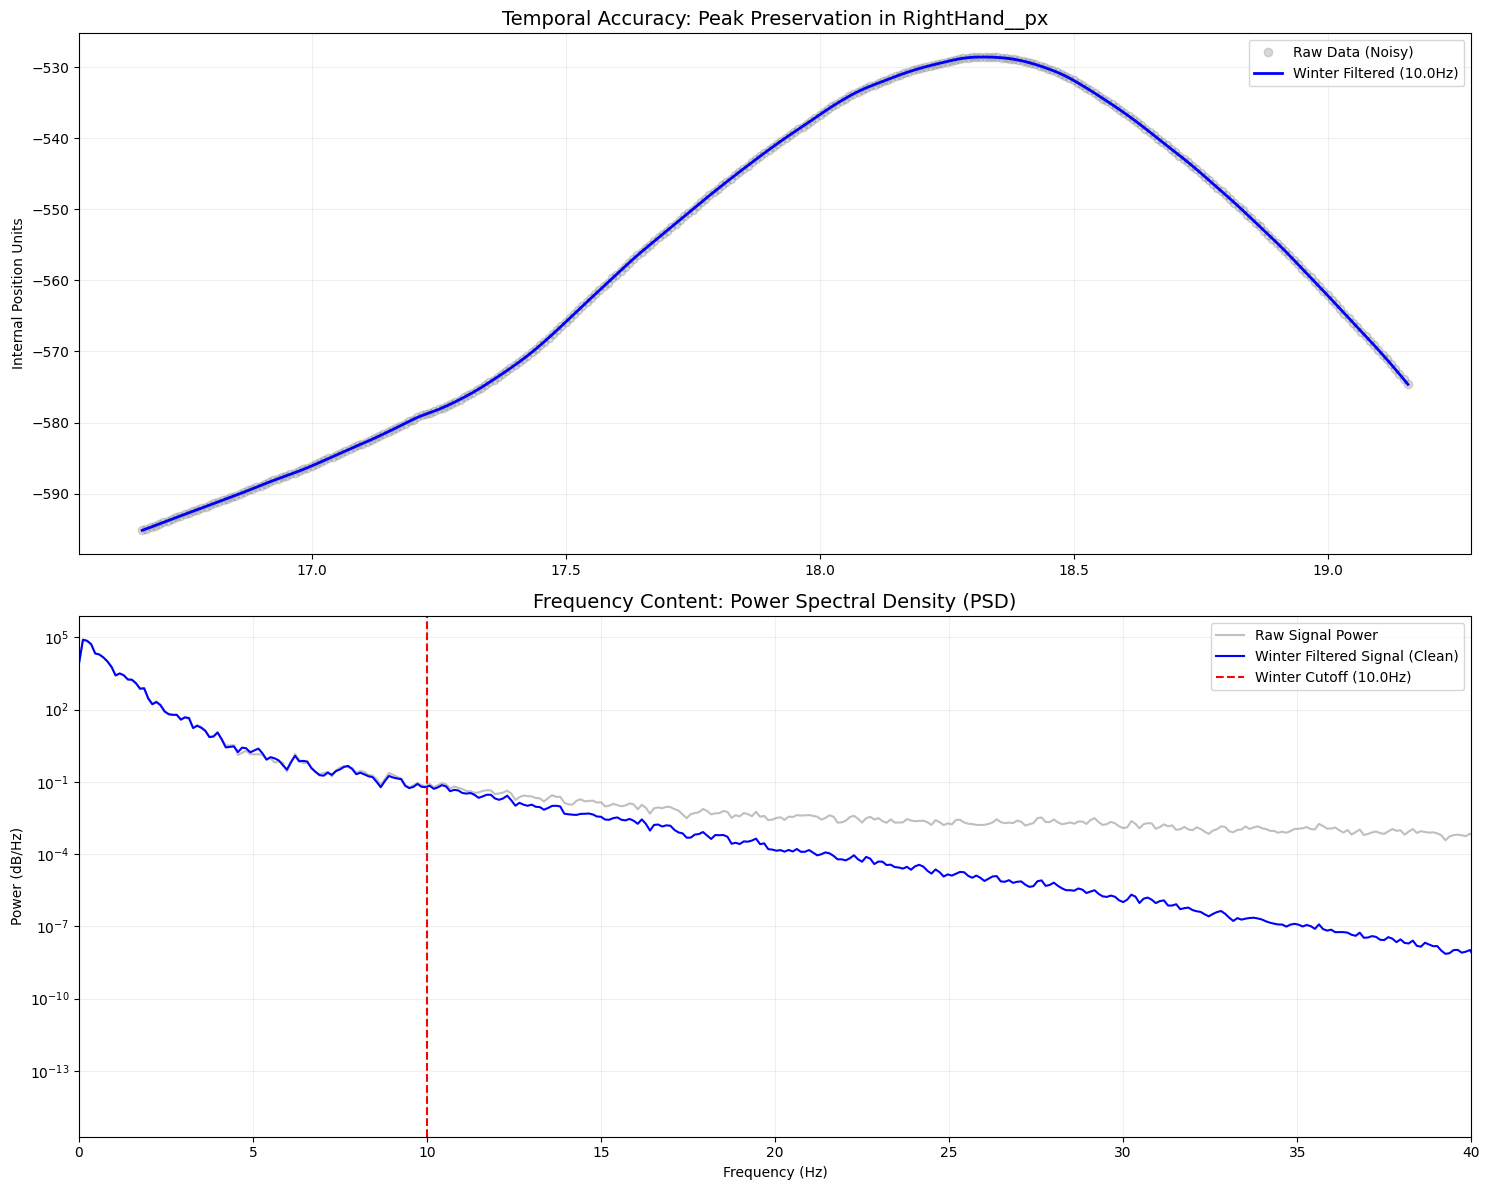

In [10]:
from scipy.signal import welch

def plot_scientific_validation(df_raw, df_filt, col, fs, cutoff):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # גרף 1: מבחן הזמן (Temporal Validation) - זום על תנועת Gaga מהירה
    start, end = 2000, 2300 # חלון של 2.5 שניות
    ax1.plot(df_raw['time_s'][start:end], df_raw[col][start:end], 'o', color='gray', alpha=0.3, label='Raw Data (Noisy)')
    ax1.plot(df_filt['time_s'][start:end], df_filt[col][start:end], color='blue', lw=2, label=f'Winter Filtered ({cutoff:.1f}Hz)')
    ax1.set_title(f"Temporal Accuracy: Peak Preservation in {col}", fontsize=14)
    ax1.set_ylabel("Internal Position Units")
    ax1.legend()
    ax1.grid(True, alpha=0.2)

    # גרף 2: מבחן התדר (Frequency Validation) - PSD
    # זה הגרף שמוכיח למבקר המאמר שלא איבדת מידע
    f_raw, p_raw = welch(df_raw[col], fs, nperseg=1024)
    f_filt, p_filt = welch(df_filt[col], fs, nperseg=1024)
    
    ax2.semilogy(f_raw, p_raw, label='Raw Signal Power', color='gray', alpha=0.5)
    ax2.semilogy(f_filt, p_filt, label='Winter Filtered Signal (Clean)', color='blue')
    ax2.axvline(cutoff, color='red', linestyle='--', label=f'Winter Cutoff ({cutoff:.1f}Hz)')
    
    ax2.set_title("Frequency Content: Power Spectral Density (PSD)", fontsize=14)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Power (dB/Hz)")
    ax2.set_xlim([0, 40]) # רוב התנועה האנושית היא מתחת ל-20Hz
    ax2.legend()
    ax2.grid(True, which='both', alpha=0.2)

    plt.tight_layout()
    plt.show()

# Run validation on right hand - location with most noise and fast movement
# Get effective cutoff (handle per-region mode)
validation_cutoff = winter_metadata.get('cutoff_hz')
if validation_cutoff is None:
    # Per-region mode: get cutoff for RightHand region
    marker_region = winter_metadata.get('marker_regions', {}).get('RightHand__px', 'upper_distal')
    validation_cutoff = winter_metadata.get('region_cutoffs', {}).get(marker_region, 10.0)
plot_scientific_validation(df, df_filtered, "RightHand__px", FS, validation_cutoff)

In [11]:
# --- CELL 05: Data Persistence & Traceability ---
# RATIONALE: Saving the filtered signal in Parquet format preserves floating-point 
# precision, which is critical for the numerical differentiation (Velocity/Acceleration) 
# in the upcoming notebooks.

# --- CELL 05: Data Persistence & Traceability ---
import shutil 

# 1. Save Filtered Kinematic Data
out_path = os.path.join(DERIV_04, f"{RUN_ID}__filtered.parquet")
df_filtered.to_parquet(out_path, index=False)

# 2. Forward the Kinematics Map
map_src = os.path.join(DERIV_03, f"{RUN_ID}__kinematics_map.json")
map_dst = os.path.join(DERIV_04, f"{RUN_ID}__kinematics_map.json")

if os.path.exists(map_src):
    shutil.copy(map_src, map_dst)
    print(f"✅ METADATA: Kinematics map forwarded to Step 04.")

print(f"🎉 SUCCESS: Filtered data saved to: {out_path}")
print(f"📊 Final Shape: {df_filtered.shape}")

✅ METADATA: Kinematics map forwarded to Step 04.
🎉 SUCCESS: Filtered data saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001__filtered.parquet
📊 Final Shape: (33958, 191)


In [12]:
# --- SCIENTIFIC UPGRADE: Signal-to-Noise Ratio (SNR) Analysis ---
# Per Cereatti et al. (2024) - Objective signal quality assessment

print("\n" + "="*80)
print("TRUE RAW SNR - CAPTURE QUALITY (Cereatti et al. 2024)")
print("="*80)
print("Method: Raw data frequency analysis (signal: 0.5-10Hz, noise: 15-50Hz)")
print("This measures inherent capture quality, NOT filtering effectiveness.")

from snr_analysis import compute_per_joint_snr, generate_snr_report

# Get joint names from position columns
pos_cols = get_position_columns(df_filtered)
joint_names = list(set(c.split('__')[0] for c in pos_cols))

print(f"Computing SNR for {len(joint_names)} joints...")

# Compute TRUE RAW SNR (from raw data frequency analysis)
# Signal: 0.5-10Hz (movement), Noise: 15-50Hz (both from RAW)
# This measures capture quality, NOT filtering effectiveness
snr_results = compute_per_joint_snr(
    df_raw=df,  # Raw data only - true SNR from frequency bands
    df_filtered=df_filtered,  # Not used for true_raw method
    joint_names=joint_names,
    fs=FS,
    method='true_raw'
)

# Generate summary report
snr_report = generate_snr_report(snr_results, min_acceptable_snr=15.0)

print(f"\nSNR Summary:")
print(f"  Mean SNR (all joints): {snr_report['mean_snr_all_joints']:.1f} dB")
print(f"  Range: [{snr_report['min_snr_all_joints']:.1f}, {snr_report['max_snr_all_joints']:.1f}] dB")
print(f"  Overall Status: {snr_report['overall_status']}")
print(f"\nQuality Breakdown:")
print(f"  ✅⭐ Excellent (>30 dB): {snr_report['joints_excellent']}")
print(f"  ✅  Good (20-30 dB): {snr_report['joints_good']}")
print(f"  ⚠️  Acceptable (15-20 dB): {snr_report['joints_acceptable']}")
print(f"  🟡  Poor (10-15 dB): {snr_report['joints_poor']}")
print(f"  ❌  Below Threshold (<10 dB): {snr_report['joints_reject']}")

if snr_report['failed_joints']:
    print(f"\n⚠️  {len(snr_report['failed_joints'])} Joints Below 15 dB Threshold:")
    for joint in snr_report['failed_joints'][:10]:
        result = snr_results[joint]
        print(f"    {joint}: {result['mean_snr_db']:.1f} dB - {result['recommendation']}")
else:
    print(f"\n✅ All joints meet minimum SNR threshold (15 dB)")

print("="*80)


TRUE RAW SNR - CAPTURE QUALITY (Cereatti et al. 2024)
Method: Raw data frequency analysis (signal: 0.5-10Hz, noise: 15-50Hz)
This measures inherent capture quality, NOT filtering effectiveness.
Computing SNR for 27 joints...

SNR Summary:
  Mean SNR (all joints): 46.4 dB
  Range: [36.2, 53.7] dB
  Overall Status: EXCELLENT

Quality Breakdown:
  ✅⭐ Excellent (>30 dB): 27
  ✅  Good (20-30 dB): 0
  ⚠️  Acceptable (15-20 dB): 0
  🟡  Poor (10-15 dB): 0
  ❌  Below Threshold (<10 dB): 0

✅ All joints meet minimum SNR threshold (15 dB)


In [13]:
import json

def export_filter_summary(df_orig, winter_meta, run_id, save_dir, fs, mass, height, snr_report=None):
    """
    RATIONALE: Documentation of Winter filter parameters and anthropometrics is 
    essential for reproducibility in biomechanical research.
    snr_report: Optional SNR summary from compute_per_joint_snr (true raw SNR).
    """
    total_frames = len(df_orig)
    missing_pct = float(df_orig.isna().mean().mean() * 100)
    
    # Check if using 3-stage pipeline - handle separately
    filtering_mode = winter_meta.get('filtering_mode', 'single_global')
    if filtering_mode == '3_stage_pipeline':
        # Extract 3-stage pipeline metadata
        pipeline_meta = winter_meta.get('pipeline_metadata', {})
        summary_stats = pipeline_meta.get('summary', {})
        stages = pipeline_meta.get('stages', {})
        per_joint = pipeline_meta.get('per_joint_results', {})
        
        # Build region cutoffs from per-joint results
        region_cutoffs = {}
        region_counts = {}
        for col, meta in per_joint.items():
            region = meta.get('marker_region', 'unknown')
            cutoff = meta.get('stage3_winter_cutoff')
            if cutoff is not None:
                if region not in region_cutoffs:
                    region_cutoffs[region] = []
                    region_counts[region] = 0
                region_cutoffs[region].append(cutoff)
                region_counts[region] += 1
        
        # Average cutoffs per region
        region_avg_cutoffs = {r: round(np.mean(c), 1) for r, c in region_cutoffs.items()}
        
        summary = {
            "run_id": run_id,
            "identity": {
                "timestamp": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
                "pipeline_version": "v3.0_3stage_signal_cleaning"
            },
            "subject_metadata": {
                "mass_kg": mass,
                "height_cm": height,
                "units_status": "internal_unscaled"
            },
            "raw_quality": {
                "total_frames": int(total_frames),
                "missing_data_percent": round(missing_pct, 3),
                "sampling_rate_actual": float(fs)
            },
            "filter_params": {
                "filter_type": "3-Stage Signal Cleaning Pipeline",
                "filter_method": "Artifact Detection + Hampel Filter + Adaptive Winter",
                "filtering_mode": "3_stage_pipeline",
                "filter_order": 2,
                "quaternion_filtering": False,
                "expected_dance_range": "1-20 Hz (Adaptive per-joint)",
                "stage1_artifact_detector": stages.get('stage1_artifact_detector', {}),
                "stage2_hampel": stages.get('stage2_hampel', {}),
                "stage3_adaptive_winter": stages.get('stage3_adaptive_winter', {}),
                "total_artifacts_detected": summary_stats.get('total_artifacts_detected', 0),
                "total_hampel_outliers": summary_stats.get('total_hampel_outliers', 0),
                "winter_cutoff_stats": summary_stats.get('winter_cutoff_stats', {}),
                "region_cutoffs": region_avg_cutoffs,
                "region_marker_counts": region_counts,
                "cutoff_range_hz": list(winter_meta.get('cutoff_range', [1.0, 20.0]))
            }
        }
        
        # Add SNR analysis if available
        if snr_report is not None:
            summary["snr_analysis"] = {
                "method": "true_raw",
                "description": "Raw data frequency analysis (signal: 0.5-10Hz, noise: 15-50Hz)",
                "mean_snr_db": round(snr_report.get('mean_snr_all_joints', 0), 1),
                "min_snr_db": round(snr_report.get('min_snr_all_joints', 0), 1),
                "max_snr_db": round(snr_report.get('max_snr_all_joints', 0), 1),
                "overall_status": snr_report.get('overall_status', 'UNKNOWN'),
                "total_joints": snr_report.get('total_joints', 0),
                "joints_excellent": snr_report.get('joints_excellent', 0),
                "joints_good": snr_report.get('joints_good', 0),
                "joints_acceptable": snr_report.get('joints_acceptable', 0),
                "joints_poor": snr_report.get('joints_poor', 0),
                "joints_reject": snr_report.get('joints_reject', 0),
                "failed_joints": snr_report.get('failed_joints', [])
            }
        
        # Save summary
        out_path = os.path.join(save_dir, f"{run_id}__filtering_summary.json")
        with open(out_path, 'w') as f:
            json.dump(summary, f, indent=4)
        
        # Print summary
        print(f"\n{'='*20} FILTER SUMMARY EXPORTED {'='*20}")
        print(f"✅ Path: {out_path}")
        print(f"📊 Quality: {missing_pct:.2f}% missing data")
        print(f"👤 Subject: {mass}kg, {height}cm")
        print(f"🔬 Filtering Mode: 3-Stage Signal Cleaning Pipeline")
        print(f"   Stage 1: Artifact Detector (velocity + z-score)")
        print(f"      - Artifacts detected: {summary_stats.get('total_artifacts_detected', 0)}")
        print(f"   Stage 2: Hampel Filter (window={stages.get('stage2_hampel', {}).get('window_size', 5)})")
        print(f"      - Outliers removed: {summary_stats.get('total_hampel_outliers', 0)}")
        print(f"   Stage 3: Adaptive Winter (per-joint)")
        cutoff_stats = summary_stats.get('winter_cutoff_stats', {})
        if cutoff_stats:
            print(f"      - Cutoff range: {cutoff_stats.get('min', 0):.1f} - {cutoff_stats.get('max', 0):.1f} Hz")
            print(f"      - Mean cutoff: {cutoff_stats.get('mean', 0):.1f} Hz")
        print(f"   Region Average Cutoffs:")
        for region, avg_cutoff in sorted(region_avg_cutoffs.items()):
            print(f"      - {region}: {avg_cutoff:.1f} Hz ({region_counts.get(region, 0)} markers)")
        print(f"{'='*60}\n")
        return  # Exit early for 3-stage pipeline
    
    # Check for Winter analysis failure - use new explicit flag from metadata
    # OLD (wrong): winter_failed = winter_meta['cutoff_hz'] >= winter_meta['fmax'] - 1
    # NEW (correct): Use the explicit failure flag that accounts for:
    #   1. No knee-point found (flat RMS curve)
    #   2. Guardrail override > 2Hz
    #   3. Cutoff at fmax
    winter_failed = winter_meta.get('winter_analysis_failed', False)
    failure_reason = winter_meta.get('winter_failure_reason', None)
    
    # Fallback check for old metadata format (backward compatibility)
    # Only check cutoff_hz if it exists (not in per-region mode)
    if not winter_failed and 'cutoff_hz' in winter_meta:
        if winter_meta['cutoff_hz'] >= winter_meta.get('fmax', 12) - 1:
            winter_failed = True
            failure_reason = f"Cutoff at fmax ({winter_meta['cutoff_hz']:.1f}Hz)"
    
    # Determine decision reason for audit trail
    # Check if using new fixed cutoff mode
    cutoff_method = winter_meta.get('cutoff_method', 'data_driven')
    
    if cutoff_method == 'fixed_literature_based':
        # New fixed cutoff mode - decision reason from metadata
        decision_reason = winter_meta.get('decision_reason', 'Fixed per-region cutoffs (Winter 2009, Robertson 2014)')
        winter_failed = False  # Fixed cutoffs don't "fail"
        failure_reason = None
    elif winter_failed:
        if failure_reason:
            cutoff_display = winter_meta.get('cutoff_hz', 'N/A')
            decision_reason = f"Filter: {failure_reason}; using {cutoff_display}Hz default" if isinstance(cutoff_display, (int, float)) else f"Filter: {failure_reason}"
        else:
            cutoff_display = winter_meta.get('cutoff_hz', 'N/A')
            decision_reason = f"Filter: No optimal knee-point found; using {cutoff_display}Hz default" if isinstance(cutoff_display, (int, float)) else f"Filter: No optimal knee-point found"
    else:
        cutoff_display = winter_meta.get('cutoff_hz', 'per-region cutoffs')
        if isinstance(cutoff_display, (int, float)):
            decision_reason = f"Filter: Winter knee-point detected at {cutoff_display:.1f}Hz"
        else:
            decision_reason = f"Filter: Per-region Winter analysis successful"
    
    # Build summary with per-region or single-cutoff filtering info
    filtering_mode = winter_meta.get('filtering_mode', 'single_global')
    
    # Determine filter method description
    # Both 'per_region' and 'per_region_fixed' use literature-based fixed cutoffs
    if filtering_mode in ['per_region', 'per_region_fixed']:
        filter_method = "Fixed Per-Region Cutoffs (Literature-Based)"
        filter_type = "Butterworth Low-pass (Zero-phase) - Winter (2009), Robertson (2014)"
    else:
        # Fallback for legacy single-cutoff mode
        filter_method = "Single Global Cutoff"
        filter_type = "Butterworth Low-pass (Zero-phase)"
    
    summary = {
        "run_id": run_id,
        "identity": {
            "timestamp": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
            "pipeline_version": "v2.9_fixed_per_region_cutoffs"
        },
        "subject_metadata": {
            "mass_kg": mass,
            "height_cm": height,
            "units_status": "internal_unscaled"
        },
        "raw_quality": {
            "total_frames": int(total_frames),
            "missing_data_percent": round(missing_pct, 3),
            "sampling_rate_actual": float(fs)
        },
        "filter_params": {
            "filter_type": filter_type,
            "filter_method": filter_method,
            "filtering_mode": filtering_mode,
            "filter_order": 2,
            "quaternion_filtering": bool(False),  # CRITICAL: Never filter quaternions
            "expected_dance_range": "8-12 Hz (Gaga athletic movement)"
        }
    }
    
    # Add per-region or single-cutoff specific information
    if filtering_mode in ['per_region', 'per_region_fixed']:
        # Per-region filtering metadata (works for both data-driven and fixed modes)
        summary["filter_params"]["region_cutoffs"] = {k: float(v) for k, v in winter_meta.get('region_cutoffs', {}).items()}
        summary["filter_params"]["cutoff_range_hz"] = [float(winter_meta['cutoff_range'][0]), float(winter_meta['cutoff_range'][1])]
        summary["filter_params"]["n_regions"] = int(winter_meta.get('n_regions', 0))
        summary["filter_params"]["fmax"] = int(winter_meta.get('fmax', 12))
        
        # Track marker classification
        marker_regions = winter_meta.get('marker_regions', {})
        region_counts = {}
        for marker, region in marker_regions.items():
            region_counts[region] = region_counts.get(region, 0) + 1
        summary["filter_params"]["region_marker_counts"] = region_counts
        
        # Add diagnostic/validation fields
        summary["filter_params"]["winter_analysis_failed"] = bool(winter_failed)
        summary["filter_params"]["winter_failure_reason"] = failure_reason
        summary["filter_params"]["decision_reason"] = decision_reason
        summary["filter_params"]["residual_rms_mm"] = float(winter_meta.get('residual_rms_mm', 0))  # Aggregate RMS across regions
        
        # Fixed cutoff specific fields
        if filtering_mode == 'per_region_fixed':
            summary["filter_params"]["cutoff_method"] = "fixed_literature_based"
            summary["filter_params"]["literature_reference"] = winter_meta.get('literature_reference', 'Winter (2009), Robertson (2014)')
            summary["filter_params"]["winter_validation_note"] = winter_meta.get('winter_validation_note', 'N/A')
        
        # Include detailed per-region analysis results
        region_analysis = winter_meta.get('region_analysis_details', {})
        if region_analysis:
            summary["filter_params"]["region_analysis_details"] = {}
            for region, details in region_analysis.items():
                region_detail = {
                    "cutoff_hz": float(details.get('cutoff_hz', 0)),
                    "rep_col": str(details.get('rep_col', 'N/A'))
                }
                # Add validation fields for fixed mode
                if filtering_mode == 'per_region_fixed':
                    region_detail["cutoff_method"] = details.get('cutoff_method', 'fixed_winter_validated')
                    region_detail["winter_strict_knee_hz"] = float(details.get('winter_strict_knee_hz', 0)) if details.get('winter_strict_knee_hz') else None
                    region_detail["winter_diminishing_hz"] = float(details.get('winter_diminishing_hz', 0)) if details.get('winter_diminishing_hz') else None
                    region_detail["winter_suggested_hz"] = float(details.get('winter_suggested_hz', 0)) if details.get('winter_suggested_hz') else None
                    region_detail["validation_status"] = details.get('validation_status', 'N/A')
                    region_detail["rationale"] = details.get('rationale', 'N/A')
                else:
                    # Data-driven mode fields
                    region_detail["raw_cutoff_hz"] = float(details.get('raw_cutoff_hz', 0)) if details.get('raw_cutoff_hz') else None
                    region_detail["knee_point_found"] = bool(details.get('knee_point_found', False))
                    region_detail["failure_reason"] = details.get('failure_reason')
                    region_detail["method_used"] = details.get('method_used')
                
                region_detail["rms_range_ratio"] = float(details.get('rms_range_ratio', 0)) if details.get('rms_range_ratio') else None
                region_detail["curve_is_flat"] = bool(details.get('curve_is_flat', False)) if details.get('curve_is_flat') is not None else None
                summary["filter_params"]["region_analysis_details"][region] = region_detail
    else:
        # Single global cutoff metadata
        summary["filter_params"]["filter_cutoff_hz"] = float(winter_meta.get('cutoff_hz', 0))
        summary["filter_params"]["filter_range_hz"] = [int(winter_meta.get('fmin', 1)), int(winter_meta.get('fmax', 12))]
        summary["filter_params"]["representative_column"] = str(winter_meta.get('rep_col', 'N/A'))
        summary["filter_params"]["winter_analysis_failed"] = bool(winter_failed)
        summary["filter_params"]["winter_failure_reason"] = failure_reason
        summary["filter_params"]["decision_reason"] = decision_reason
        
        # Add biomechanical guardrails information if available
        if 'biomechanical_guardrails' in winter_meta:
            guardrails = winter_meta['biomechanical_guardrails']
            summary["filter_params"]["biomechanical_guardrails"] = {
                "enabled": bool(guardrails['enabled']),
                "strategy": str(guardrails['strategy']),
                "min_cutoff_trunk_hz": float(guardrails['min_cutoff_trunk']) if guardrails['min_cutoff_trunk'] is not None else None,
                "min_cutoff_distal_hz": float(guardrails['min_cutoff_distal']) if guardrails['min_cutoff_distal'] is not None else None,
                "use_trunk_global": bool(guardrails['use_trunk_global'])
            }
    
    # Add TRUE RAW SNR to summary (measures capture quality from raw data)
    if snr_report is not None:
        summary["snr_analysis"] = {
            "method": "true_raw",
            "description": "Raw data frequency analysis (signal: 0.5-10Hz, noise: 15-50Hz)",
            "mean_snr_db": round(snr_report.get('mean_snr_all_joints', 0), 1),
            "min_snr_db": round(snr_report.get('min_snr_all_joints', 0), 1),
            "max_snr_db": round(snr_report.get('max_snr_all_joints', 0), 1),
            "overall_status": snr_report.get('overall_status', 'UNKNOWN'),
            "total_joints": snr_report.get('total_joints', 0),
            "joints_excellent": snr_report.get('joints_excellent', 0),
            "joints_good": snr_report.get('joints_good', 0),
            "joints_acceptable": snr_report.get('joints_acceptable', 0),
            "joints_poor": snr_report.get('joints_poor', 0),
            "joints_reject": snr_report.get('joints_reject', 0),
            "failed_joints": snr_report.get('failed_joints', [])
        }
    
    out_path = os.path.join(save_dir, f"{run_id}__filtering_summary.json")
    with open(out_path, 'w') as f:
        json.dump(summary, f, indent=4)
    
    print(f"\n{'='*20} FILTER SUMMARY EXPORTED {'='*20}")
    print(f"✅ Path: {out_path}")
    print(f"📊 Quality: {missing_pct:.2f}% missing data")
    print(f"👤 Subject: {mass}kg, {height}cm")
    
    # Show per-region or single cutoff info
    if filtering_mode == 'per_region_fixed':
        print(f"🔬 Filtering Mode: FIXED Per-Region Cutoffs (Literature-Based)")
        print(f"📚 Reference: Winter (2009), Robertson (2014)")
        cutoff_range = winter_meta.get('cutoff_range', (0, 0))
        print(f"📈 Cutoff Range: {cutoff_range[0]:.1f} - {cutoff_range[1]:.1f} Hz")
        print(f"🎯 Fixed Region Cutoffs:")
        region_analysis = winter_meta.get('region_analysis_details', {})
        for region, cutoff in winter_meta.get('region_cutoffs', {}).items():
            n_markers = len([m for m, r in winter_meta.get('marker_regions', {}).items() if r == region])
            details = region_analysis.get(region, {})
            strict_knee = details.get('winter_strict_knee_hz', details.get('winter_suggested_hz', 'N/A'))
            diminishing = details.get('winter_diminishing_hz', 'N/A')
            validation = details.get('validation_status', 'N/A')
            if isinstance(strict_knee, (int, float)) and isinstance(diminishing, (int, float)):
                print(f"     {region:20s}: {cutoff:4.0f} Hz | RMS knee: {strict_knee:.0f}Hz, diminishing: {diminishing:.0f}Hz | {validation} - {n_markers} markers")
            elif isinstance(strict_knee, (int, float)):
                print(f"     {region:20s}: {cutoff:4.0f} Hz | RMS knee: {strict_knee:.0f}Hz | {validation} - {n_markers} markers")
            else:
                print(f"     {region:20s}: {cutoff:4.0f} Hz - {n_markers} markers")
        validation_note = winter_meta.get('winter_validation_note', '')
        if validation_note:
            print(f"✅ Validation: {validation_note[:100]}...")
    elif filtering_mode == 'per_region':
        print(f"🔬 Filtering Mode: Per-Region (Data-Driven)")
        cutoff_range = winter_meta.get('cutoff_range', (0, 0))
        print(f"📈 Cutoff Range: {cutoff_range[0]:.1f} - {cutoff_range[1]:.1f} Hz")
        print(f"🎯 Region Cutoffs:")
        for region, cutoff in winter_meta.get('region_cutoffs', {}).items():
            n_markers = len([m for m, r in winter_meta.get('marker_regions', {}).items() if r == region])
            print(f"     {region:20s}: {cutoff:4.1f} Hz ({n_markers} markers)")
    else:
        print(f"🔬 Winter Cutoff: {winter_meta.get('cutoff_hz', 0):.1f} Hz")
        print(f"📈 Rep Column: {winter_meta.get('rep_col', 'N/A')}")
        print(f"🔄 Range: 1-12 Hz (Conservative for dance)")
        
        # Show biomechanical guardrails info
        if 'biomechanical_guardrails' in winter_meta:
            guardrails = winter_meta['biomechanical_guardrails']
            print(f"🛡️  Guardrails: {guardrails['strategy']}")
            print(f"   Min cutoffs: Trunk={guardrails['min_cutoff_trunk']} Hz, Distal={guardrails['min_cutoff_distal']} Hz")
        
        if winter_failed:
            print(f"ℹ️  Winter RMS Analysis: Would suggest fmax (diagnostic only)")
            print(f"   Note: Fixed literature cutoffs are used regardless")
            print(f"   Decision: {decision_reason}")
        else:
            print(f"ℹ️  Winter RMS Analysis: Agrees with fixed cutoffs")
            print(f"   Decision: {decision_reason}")
    
    print(f"{'='*60}\n")

# Export filtering summary with SNR analysis
export_filter_summary(df, winter_metadata, RUN_ID, DERIV_04, FS, SUBJECT_MASS, SUBJECT_HEIGHT, snr_report=snr_report)

# Enhancement 3: Export Winter residual curve data for Master Audit plotting
print(f"{'='*20} EXPORTING WINTER RESIDUAL DATA {'='*20}")
try:
    from winter_export import export_winter_residual_data
    residual_path = export_winter_residual_data(winter_metadata, RUN_ID, DERIV_04)
    print(f"Winter Residual Data: {residual_path}")
    print(f"Purpose: Enables inline RMS residual plotting in Master Audit")
    print(f"{'='*60}\n")
except Exception as e:
    print(f"Winter residual export failed: {e}")
    print(f"   Note: Residual curve data may not be in winter_metadata")
    print(f"   Master Audit will use summary data only")
    print(f"{'='*60}\n")


==================== FILTER SUMMARY EXPORTED ====================
✅ Path: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001__filtering_summary.json
📊 Quality: 0.00% missing data
👤 Subject: Nonekg, Nonecm
🔬 Filtering Mode: 3-Stage Signal Cleaning Pipeline
   Stage 1: Artifact Detector (velocity + z-score)
      - Artifacts detected: 17440
   Stage 2: Hampel Filter (window=5)
      - Outliers removed: 7500
   Stage 3: Adaptive Winter (per-joint)
      - Cutoff range: 14.5 - 15.2 Hz
      - Mean cutoff: 14.9 Hz
   Region Average Cutoffs:
      - head: 14.5 Hz (6 markers)
      - lower_distal: 15.1 Hz (18 markers)
      - lower_proximal: 14.7 Hz (6 markers)
      - trunk: 14.7 Hz (9 markers)
      - upper_distal: 15.2 Hz (24 markers)
      - upper_proximal: 14.5 Hz (18 markers)

==================== EXPORTING WINTER RESIDUAL DATA ====================
Winter Residual Data: c:\Users\drorh\OneDrive - Mobileye\Desktop\ga

In [14]:
# ============================================================
# AUDIT PREVIEW - Values exported to Master Quality Report (NB07)
# ============================================================
# This cell shows exactly what will appear in the master audit xlsx

print("\n" + "="*80)
print("AUDIT PREVIEW - VALUES FOR MASTER QUALITY REPORT (NB07)")
print("="*80)
print(f"Run ID: {RUN_ID}")
print()

# Load the just-exported filtering summary
summary_path = os.path.join(DERIV_04, f"{RUN_ID}__filtering_summary.json")
with open(summary_path, 'r') as f:
    summary = json.load(f)

# --- SECTION: Subject Metadata ---
print("[SUBJECT METADATA]")
print(f"  Subject_Mass_kg: {summary.get('subject_metadata', {}).get('mass_kg', 'N/A')}")
print()

# --- SECTION: Filtering Parameters ---
fp = summary.get('filter_params', {})
filtering_mode = fp.get('filtering_mode', 'N/A')
print("[FILTERING PARAMETERS]")
print(f"  Filtering_Mode: {filtering_mode}")

if filtering_mode == '3_stage_pipeline':
    # 3-Stage Pipeline specific display
    print(f"  Filter_Type: {fp.get('filter_type', 'N/A')}")
    print(f"  Stage1_Artifacts_Detected: {fp.get('total_artifacts_detected', 0)}")
    print(f"  Stage2_Hampel_Outliers: {fp.get('total_hampel_outliers', 0)}")
    cutoff_stats = fp.get('winter_cutoff_stats', {})
    if cutoff_stats:
        print(f"  Stage3_Cutoff_Range: {cutoff_stats.get('min', 0):.1f} - {cutoff_stats.get('max', 0):.1f} Hz")
        print(f"  Stage3_Mean_Cutoff: {cutoff_stats.get('mean', 0):.1f} Hz")
        print(f"  Stage3_Median_Cutoff: {cutoff_stats.get('median', 0):.1f} Hz")
    print(f"  Region_Cutoffs_Avg: {fp.get('region_cutoffs', {})}")
    print()
    
    # --- SECTION: 3-Stage Pipeline Diagnostics ---
    print("[3-STAGE PIPELINE DIAGNOSTICS]")
    s1 = fp.get('stage1_artifact_detector', {})
    s2 = fp.get('stage2_hampel', {})
    s3 = fp.get('stage3_adaptive_winter', {})
    print(f"  Stage1_Velocity_Limit: {s1.get('velocity_limit', 'N/A')} mm/s")
    print(f"  Stage1_ZScore_Threshold: {s1.get('zscore_threshold', 'N/A')}σ")
    print(f"  Stage2_Window_Size: {s2.get('window_size', 'N/A')} frames")
    print(f"  Stage2_N_Sigma: {s2.get('n_sigma', 'N/A')}σ")
    print(f"  Stage3_Freq_Range: {s3.get('fmin', 'N/A')} - {s3.get('fmax', 'N/A')} Hz")
    print(f"  Stage3_Per_Joint: {s3.get('per_joint', 'N/A')}")
    print()
else:
    # Traditional mode display
    print(f"  Region_Cutoffs_Applied: {fp.get('region_cutoffs', 'N/A')}")
    rms_val = fp.get('residual_rms_mm', 'N/A')
    print(f"  Residual_RMS_mm: {round(rms_val, 2) if isinstance(rms_val, (int, float)) else rms_val}")
    print()

    # --- SECTION: Per-Region Winter Validation ---
    print("[PER-REGION DIAGNOSTICS - RMS ANALYSIS]")
    region_details = fp.get('region_analysis_details', {})
    rms_knee = {}
    diminishing = {}
    validation_status = {}
    for region, details in region_details.items():
        rms_knee[region] = details.get('winter_strict_knee_hz') or details.get('winter_suggested_hz', 'N/A')
        diminishing[region] = details.get('winter_diminishing_hz', 'N/A')
        validation_status[region] = details.get('validation_status', 'N/A')
    print(f"  RMS_Knee_Per_Region: {rms_knee}")
    print(f"  Diminishing_Per_Region: {diminishing}")
    print(f"  Region_Validation_Status: {validation_status}")
    print()

# --- SECTION: TRUE RAW SNR ---
snr = summary.get('snr_analysis', {})
print("[TRUE RAW SNR - CAPTURE QUALITY]")
print(f"  Raw_SNR_Mean_dB: {snr.get('mean_snr_db', 'N/A')}")
print(f"  Raw_SNR_Min_dB: {snr.get('min_snr_db', 'N/A')}")
print(f"  Raw_SNR_Max_dB: {snr.get('max_snr_db', 'N/A')}")
print(f"  Raw_SNR_Status: {snr.get('overall_status', 'N/A')}")
print(f"  Raw_SNR_Joints_Excellent: {snr.get('joints_excellent', 'N/A')}")
print(f"  Raw_SNR_Failed_Joints: {snr.get('failed_joints', [])}")
print()

print("="*80)
print("NOTE: These values will appear in the Master Audit Excel (NB07)")
print("      Run 07_master_quality_report.ipynb to generate the full report.")
print("="*80)


AUDIT PREVIEW - VALUES FOR MASTER QUALITY REPORT (NB07)
Run ID: 734_T3_P1_R1_Take 2025-12-30 04.12.54 PM_001

[SUBJECT METADATA]
  Subject_Mass_kg: None

[FILTERING PARAMETERS]
  Filtering_Mode: 3_stage_pipeline
  Filter_Type: 3-Stage Signal Cleaning Pipeline
  Stage1_Artifacts_Detected: 17440
  Stage2_Hampel_Outliers: 7500
  Stage3_Cutoff_Range: 14.5 - 15.2 Hz
  Stage3_Mean_Cutoff: 14.9 Hz
  Stage3_Median_Cutoff: 15.2 Hz
  Region_Cutoffs_Avg: {'lower_distal': 15.1, 'head': 14.5, 'lower_proximal': 14.7, 'upper_proximal': 14.5, 'trunk': 14.7, 'upper_distal': 15.2}

[3-STAGE PIPELINE DIAGNOSTICS]
  Stage1_Velocity_Limit: 5000.0 mm/s
  Stage1_ZScore_Threshold: 5.0σ
  Stage2_Window_Size: 5 frames
  Stage2_N_Sigma: 3.0σ
  Stage3_Freq_Range: 1.0 - 20.0 Hz
  Stage3_Per_Joint: True

[TRUE RAW SNR - CAPTURE QUALITY]
  Raw_SNR_Mean_dB: 46.4
  Raw_SNR_Min_dB: 36.2
  Raw_SNR_Max_dB: 53.7
  Raw_SNR_Status: EXCELLENT
  Raw_SNR_Joints_Excellent: 27
  Raw_SNR_Failed_Joints: []

NOTE: These values wil